In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import os
import torchvision
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets ,transforms 
from torch.utils.data import DataLoader ,random_split
from torchvision.io import read_image
import torch.nn.functional as F

torch.manual_seed(2021)
# Device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# read data sets without change png or jpg and without structure the data
data_dir = '/kaggle/input/sport-data-sub2022/Train'
images_list = os.listdir(data_dir)
df =pd.DataFrame({'dirs':images_list})
df['label'] = df['dirs'].str.replace('_\d+.\w{3}',"",regex= True)

#data set class
class sport_dataset(datasets.DatasetFolder):  
  def __init__(self, root,df ,transform=None, target_transform=None):
    self.class_to_idx= { 
          'Basketball': 0, 'Football':1,
          'Rowing':2,'Swimming':3,
          'Tennis':4,'Yoga':5}
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    df['label'] = df['label'].map(self.class_to_idx)
    
    self.dir = root if root[-1] == '/' else root+'/'
    self.image_labels = df['label'].tolist()
    self.images = df['dirs'].tolist()
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.image_labels)

  def __getitem__(self, idx):
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    label = self.image_labels[idx]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

class sport_dataset_test(datasets.DatasetFolder): 
  def __init__(self, root ,transform=None, target_transform=None):
    self.dir = root if root[-1] == '/' else root+'/'
    df= pd.DataFrame({'dirs':os.listdir(root)})
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    self.images = df["dirs"].to_list()
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
        
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    if self.transform:
        image = self.transform(image)
    return image, self.images[idx]

In [30]:
num_classes = 6
num_epochs = 50
BATCH_SIZE = 8
learning_rate = 2e-4

In [31]:
data_dir = '/kaggle/input/sport-data-sub2022/Train'
test_dir = '/kaggle/input/sport-data-sub2022/Test'
split_size = 0.2
train_df, val_df = train_test_split(df, test_size=split_size, shuffle=True,stratify=df[['label']])

In [32]:
df['label'].value_counts()

Yoga          458
Football      400
Swimming      240
Rowing        202
Basketball    196
Tennis        185
Name: label, dtype: int64

In [33]:
vc = train_df.label.value_counts()
vct=vc.max() - vc
for clas , value in vct.to_dict().items():
    smaple_df = train_df.loc[train_df['label']==clas ,:]

    if value > 0:
        train_df = train_df.append(smaple_df.sample(value,replace= True,random_state =49), ignore_index=True)
train_df['label'].value_counts()

Tennis        366
Football      366
Basketball    366
Yoga          366
Rowing        366
Swimming      366
Name: label, dtype: int64

In [34]:
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.2) ,
                                     transforms.RandomHorizontalFlip(p=0.2), 
                                     transforms.RandomPerspective(distortion_scale=0.3,p=0.2),
                                     transforms.RandomRotation(degrees=45,),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

tranform_test = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, train_df  ,transform=tranform_train)
val = sport_dataset(data_dir, val_df ,transform=tranform_test)
test = sport_dataset_test(test_dir, transform=tranform_test)

# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True,num_workers=2)
valid_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False,num_workers=2)
test_loader = DataLoader(test, batch_size=1,  shuffle=False ,num_workers=2)
# print train test val sizes
print(train.class_to_idx)
print(f'''
Train data size : {len(train)}  
Val data size   : {len(val)} 
Test data size  : {len(test)}
''')

{'Basketball': 0, 'Football': 1, 'Rowing': 2, 'Swimming': 3, 'Tennis': 4, 'Yoga': 5}

Train data size : 2196  
Val data size   : 337 
Test data size  : 688



images.shape: torch.Size([8, 3, 224, 224])


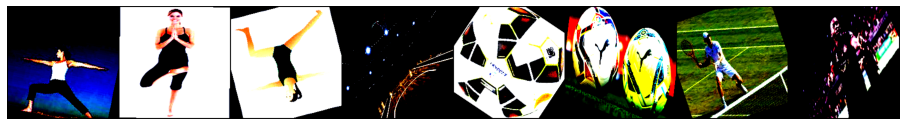

In [35]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Residual Block

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU(inplace = True))
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.SiLU(inplace = True)
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet

In [37]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 6):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.SiLU(inplace = True))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Setting Hyperparameters

In [38]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
# Loss and optimizer
weights =  torch.tensor([1.2,1.2,1.1,1.1,1.5,1]).to(device).float()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.99,0.999))  

# Train the model
total_step = len(train_loader)

In [39]:
#model.classifier[1] = nn.Linear(in_features=1280, out_features=6, bias=True).to(device)
# Loss and optimizer

# Training:

In [40]:
import gc
train_losses = []
val_losses = []
train_acc = []
val_acc = []
acc_old = 0 

total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
       
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)
            
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
          acc_old = val_acc[-1]
          torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), 100 * correct / total)    )
        


Epoch [1/50]: 
              T_Loss: 1.6063 , T_ACC: 25.1366% , validation:  Val_Loss: 1.6097 , Val_ACC: 25.8160%

Epoch [2/50]: 
              T_Loss: 1.2727 , T_ACC: 30.3279% , validation:  Val_Loss: 1.4267 , Val_ACC: 32.3442%

Epoch [3/50]: 
              T_Loss: 1.2124 , T_ACC: 35.9745% , validation:  Val_Loss: 0.4697 , Val_ACC: 45.9941%

Epoch [4/50]: 
              T_Loss: 1.3329 , T_ACC: 45.7195% , validation:  Val_Loss: 0.1344 , Val_ACC: 61.7211%

Epoch [5/50]: 
              T_Loss: 1.3556 , T_ACC: 53.5974% , validation:  Val_Loss: 0.0833 , Val_ACC: 67.9525%

Epoch [6/50]: 
              T_Loss: 0.6823 , T_ACC: 58.6521% , validation:  Val_Loss: 0.0923 , Val_ACC: 70.9199%

Epoch [7/50]: 
              T_Loss: 1.3137 , T_ACC: 59.2441% , validation:  Val_Loss: 0.1196 , Val_ACC: 72.1068%

Epoch [8/50]: 
              T_Loss: 2.3948 , T_ACC: 63.5246% , validation:  Val_Loss: 0.1160 , Val_ACC: 69.1395%

Epoch [9/50]: 
              T_Loss: 0.6511 , T_ACC: 66.3934% , validation:  Va

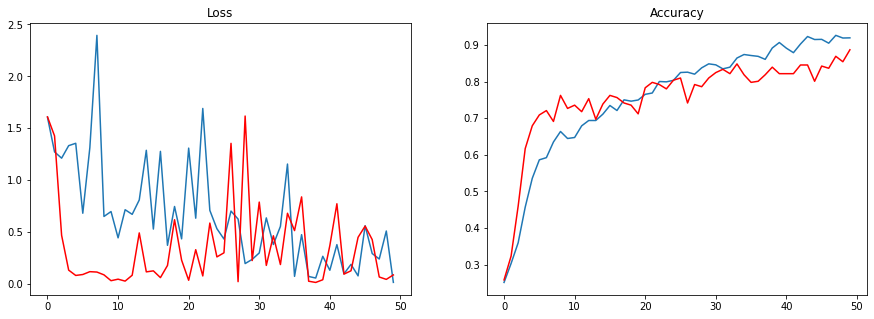

In [41]:
model.load_state_dict(torch.load('best_model_xc.pt'))
model.eval()
fig2, ax = plt.subplots(1,2,  figsize=(15,5))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[0].plot(val_losses,'-r')
ax[1].plot(val_acc,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

In [42]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

maxmium valadtion accuarcy : 0.8872% at Epoch 50 


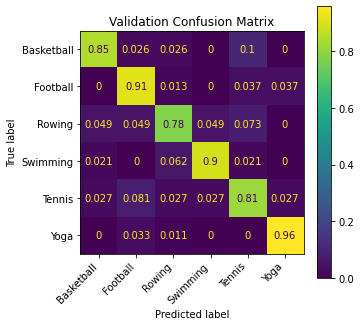

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

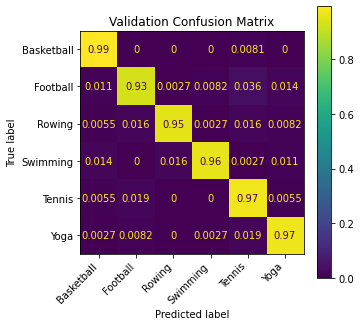

In [47]:
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show() 

In [48]:
learning_rate = 5e-6
num_epochs = 20
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.3) ,
                                     transforms.RandomHorizontalFlip(p=0.3), 
                                     transforms.RandomPerspective(distortion_scale=0.3,p=0.3),
                                     transforms.RandomRotation(degrees=45,),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, df  ,transform=tranform_train)
# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True,num_workers=2)

weights =  torch.tensor([1,1.2,1.2,1.2,1.3,1]).to(device).float()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.99,0.999))  

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
       
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)
            
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
          acc_old = val_acc[-1]
          torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), 100 * correct / total)    )
        


Epoch [1/20]: 
              T_Loss: 0.1780 , T_ACC: 90.7198% , validation:  Val_Loss: 0.0380 , Val_ACC: 88.4273%

Epoch [2/20]: 
              T_Loss: 0.1347 , T_ACC: 93.1588% , validation:  Val_Loss: 0.0269 , Val_ACC: 88.1306%

Epoch [3/20]: 
              T_Loss: 0.0608 , T_ACC: 92.9209% , validation:  Val_Loss: 0.0239 , Val_ACC: 87.8338%

Epoch [4/20]: 
              T_Loss: 0.0045 , T_ACC: 92.1475% , validation:  Val_Loss: 0.0279 , Val_ACC: 89.6142%

Epoch [5/20]: 
              T_Loss: 0.3108 , T_ACC: 92.3855% , validation:  Val_Loss: 0.0180 , Val_ACC: 88.4273%

Epoch [6/20]: 
              T_Loss: 0.0171 , T_ACC: 93.4563% , validation:  Val_Loss: 0.0095 , Val_ACC: 89.6142%

Epoch [7/20]: 
              T_Loss: 0.0707 , T_ACC: 93.3968% , validation:  Val_Loss: 0.0111 , Val_ACC: 90.8012%

Epoch [8/20]: 
              T_Loss: 0.0597 , T_ACC: 93.0993% , validation:  Val_Loss: 0.0156 , Val_ACC: 90.2077%

Epoch [9/20]: 
              T_Loss: 0.1429 , T_ACC: 93.3968% , validation:  Va

maxmium valadtion accuarcy : 0.9169% at Epoch 70 


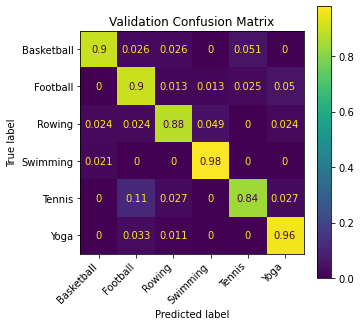

In [49]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

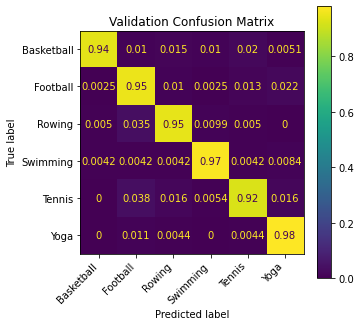

In [50]:
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show() 

In [51]:
learning_rate = 5e-6
num_epochs = 40
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.3) ,
                                     transforms.RandomHorizontalFlip(p=0.35), 
                                     transforms.RandomPerspective(distortion_scale=0.43,p=0.35),
                                     transforms.RandomRotation(degrees=45,),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, df  ,transform=tranform_train)
# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True,num_workers=2)

weights =  torch.tensor([1.1,1.2,1.2,1.1,1.3,1]).to(device).float()
criterion = nn.CrossEntropyLoss(weights,label_smoothing=0.02)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.99,0.999))  

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
       
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)
            
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
          acc_old = val_acc[-1]
          torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), 100 * correct / total)    )
        


Epoch [1/40]: 
              T_Loss: 1.1315 , T_ACC: 93.6942% , validation:  Val_Loss: 0.1446 , Val_ACC: 91.3947%

Epoch [2/40]: 
              T_Loss: 0.3930 , T_ACC: 93.8132% , validation:  Val_Loss: 0.1455 , Val_ACC: 91.6914%

Epoch [3/40]: 
              T_Loss: 0.1652 , T_ACC: 93.4563% , validation:  Val_Loss: 0.1509 , Val_ACC: 92.2849%

Epoch [4/40]: 
              T_Loss: 0.1627 , T_ACC: 94.0512% , validation:  Val_Loss: 0.1467 , Val_ACC: 92.2849%

Epoch [6/40]: 
              T_Loss: 0.2625 , T_ACC: 93.5158% , validation:  Val_Loss: 0.1615 , Val_ACC: 92.5816%

Epoch [7/40]: 
              T_Loss: 0.3018 , T_ACC: 94.2296% , validation:  Val_Loss: 0.1485 , Val_ACC: 93.1751%

Epoch [8/40]: 
              T_Loss: 0.6239 , T_ACC: 93.5158% , validation:  Val_Loss: 0.1507 , Val_ACC: 92.8783%

Epoch [9/40]: 
              T_Loss: 0.4592 , T_ACC: 94.6460% , validation:  Val_Loss: 0.1491 , Val_ACC: 92.5816%

Epoch [10/40]: 
              T_Loss: 0.2413 , T_ACC: 94.2891% , validation:  V

maxmium valadtion accuarcy : 0.9496% at Epoch 110 


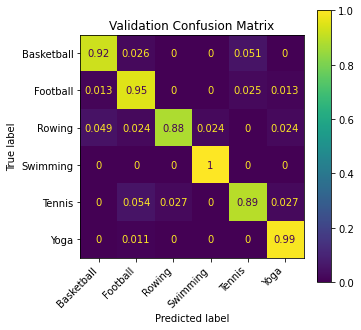

In [52]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

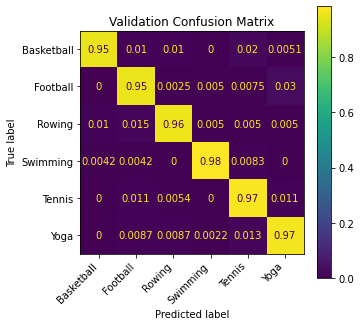

In [53]:
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show() 

In [54]:
learning_rate = 3e-6
num_epochs = 60
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.3) ,
                                     transforms.RandomHorizontalFlip(p=0.3), 
                                     transforms.RandomPerspective(distortion_scale=0.436,p=0.4),
                                     transforms.RandomRotation(degrees=50,),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, df  ,transform=tranform_train)
# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True,num_workers=2)

weights =  torch.tensor([1.15,1.2,1.2,1.1,1.3,1]).to(device).float()
criterion = nn.CrossEntropyLoss(weights,label_smoothing=0.02)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.99,0.999))  

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
       
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)
            
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
          acc_old = val_acc[-1]
          torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), 100 * correct / total)    )
        


Epoch [1/60]: 
              T_Loss: 0.1737 , T_ACC: 94.3486% , validation:  Val_Loss: 0.1558 , Val_ACC: 94.3620%

Epoch [2/60]: 
              T_Loss: 0.1707 , T_ACC: 95.3004% , validation:  Val_Loss: 0.1509 , Val_ACC: 94.6588%

Epoch [3/60]: 
              T_Loss: 0.4912 , T_ACC: 95.3599% , validation:  Val_Loss: 0.1448 , Val_ACC: 94.9555%

Epoch [4/60]: 
              T_Loss: 0.5862 , T_ACC: 95.1814% , validation:  Val_Loss: 0.1586 , Val_ACC: 94.3620%

Epoch [5/60]: 
              T_Loss: 0.4352 , T_ACC: 95.7168% , validation:  Val_Loss: 0.1524 , Val_ACC: 94.6588%

Epoch [6/60]: 
              T_Loss: 0.2724 , T_ACC: 94.8245% , validation:  Val_Loss: 0.1474 , Val_ACC: 94.3620%

Epoch [7/60]: 
              T_Loss: 0.3976 , T_ACC: 94.8840% , validation:  Val_Loss: 0.1561 , Val_ACC: 93.7685%

Epoch [8/60]: 
              T_Loss: 0.2120 , T_ACC: 95.4194% , validation:  Val_Loss: 0.1585 , Val_ACC: 94.6588%

Epoch [9/60]: 
              T_Loss: 0.6717 , T_ACC: 94.7650% , validation:  Va

maxmium valadtion accuarcy : 0.9644% at Epoch 167 


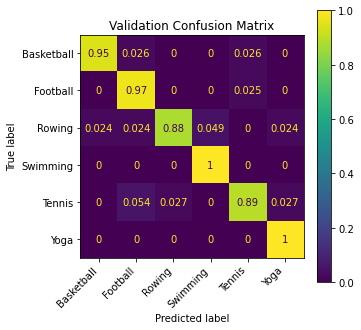

In [55]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

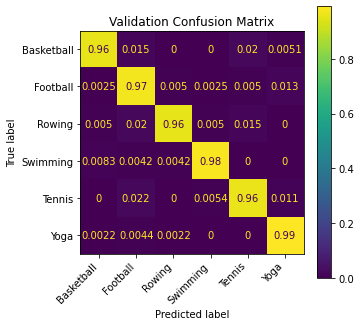

In [56]:
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show() 

# Testing:

In [59]:
pred_df  = pd.DataFrame(columns=['image_name','label'], index=range(len(test)))
with torch.no_grad():
    for idx, (images, name) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.max(1)[1].cpu().numpy()[0]
        pred_df.iloc[idx,:] =[name[0],predicted] 
        del images, outputs
pred_df.head(5)

,image_name,label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1


In [62]:
pred_df.to_csv("resnet_labels.csv")
torch.save(model.state_dict(), f"resnet_model_val_score{max(val_acc):.4}.pt")